In [42]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
import os
import struct
import numpy as np
import cv2
from keras.utils import to_categorical
#from keras.models import Sequential
#from keras.layers import Flatten, Dense, BatchNormalization

In [43]:
def load_dataset(path):
    images = []
    labels = []
    class_folders = os.listdir(path)
    for i, class_folder in enumerate(class_folders):
        class_path = os.path.join(path, class_folder)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            # Resize the image to 28x28 if needed
            image = cv2.resize(image, (28, 28))
            images.append(image)
            labels.append(i)
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

# Load and preprocess the dataset
path = 'C:\\Users\\parva\\Desktop\\mldlnew\\brain_dataset\\Training'
x_train, y_train = load_dataset(path)
x_train = x_train / 255.0
y_train = to_categorical(y_train)

# Load and preprocess the test dataset
path = 'C:\\Users\\parva\\Desktop\\mldlnew\\brain_dataset\\Testing'
x_test, y_test = load_dataset(path)
x_test = x_test / 255.0
y_test = to_categorical(y_test)



In [44]:
# Build the DNN model
model = Sequential([
    Flatten(input_shape=(28, 28, 1)),  # Input shape for grayscale images
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dense(4, activation='softmax')  # Adjusted to match number of classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

c:\Users\parva\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [45]:
import matplotlib.pyplot as plt

# Train the model and store the training history
history = model.fit(x_train, y_train, epochs=80, batch_size=32, validation_data=(x_test, y_test))

# Evaluate the model on the training data
_, training_accuracy = model.evaluate(x_train, y_train)
print(f'Training Accuracy: {training_accuracy}')

# Evaluate the model on the testing data
_, testing_accuracy = model.evaluate(x_test, y_test)
print(f'Testing Accuracy: {testing_accuracy}')

Epoch 1/80
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5814 - loss: 1.1159 - val_accuracy: 0.3452 - val_loss: 1.8300
Epoch 2/80
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7922 - loss: 0.5568 - val_accuracy: 0.3782 - val_loss: 2.1154
Epoch 3/80
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8260 - loss: 0.4555 - val_accuracy: 0.5102 - val_loss: 1.5025
Epoch 4/80
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8300 - loss: 0.4326 - val_accuracy: 0.4924 - val_loss: 1.9333
Epoch 5/80
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8789 - loss: 0.3411 - val_accuracy: 0.5381 - val_loss: 2.0154
Epoch 6/80
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8978 - loss: 0.3051 - val_accuracy: 0.5457 - val_loss: 1.8923
Epoch 7/80
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9037 - loss: 0.2914 - val_accuracy: 0.6015 - val_loss: 2.1956
Epoch 8/80
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9060 - loss: 0.2734 - val_accuracy: 0.5838 - val_loss:

In [46]:
#--------------------- BIM Attack -------------------

def bim_attack(model, images, labels, epsilon=0.01, epsilon_iter=0.005, num_steps=10):
    adv_images = images.copy()
    for _ in range(num_steps):
        adv_images = fgsm_attack_step(model, adv_images, labels, epsilon_iter)
        adv_images = np.clip(adv_images, images - epsilon, images + epsilon)
        adv_images = np.clip(adv_images, 0, 1)  # Ensure pixel values are in [0, 1] range
    return adv_images

def fgsm_attack_step(model, images, labels, epsilon):
    images_adv = images + epsilon * np.sign(compute_gradients(model, images, labels))
    return images_adv

def compute_gradients(model, images, labels):
    images_tensor = tf.convert_to_tensor(images, dtype=tf.float32)
    labels_categorical = tf.convert_to_tensor(labels, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(images_tensor)
        predictions = model(images_tensor)
        loss = tf.keras.losses.categorical_crossentropy(labels_categorical, predictions)
    gradients = tape.gradient(loss, images_tensor)
    return gradients.numpy()

In [47]:
#-------------------- BIM Attack Evaluation -------------------

# Perform the attack on the full test data
epsilon = 0.01  # Perturbation size
epsilon_iter = 0.05  # Size of perturbation per iteration
num_steps = 20  # Number of iterations
x_test_adv_bim = bim_attack(model, x_test, y_test, epsilon, epsilon_iter, num_steps)

# Evaluate the adversarially attacked model
_, adv_testing_accuracy = model.evaluate(x_test_adv_bim, y_test)
print(f'Adversarial Testing Accuracy: {adv_testing_accuracy}')

# Evaluate the success rate of the attack on the subset
y_pred_adv_subset = np.argmax(model.predict(x_test_adv_bim), axis=1)
success_rate_subset = np.mean(y_pred_adv_subset != np.argmax(y_test, axis=1))
print("Success rate of the BIM attack on the subset:", success_rate_subset)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0564 - loss: 14.9054     
Adversarial Testing Accuracy: 0.10913705825805664
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Success rate of the BIM attack on the subset: 0.8908629441624365


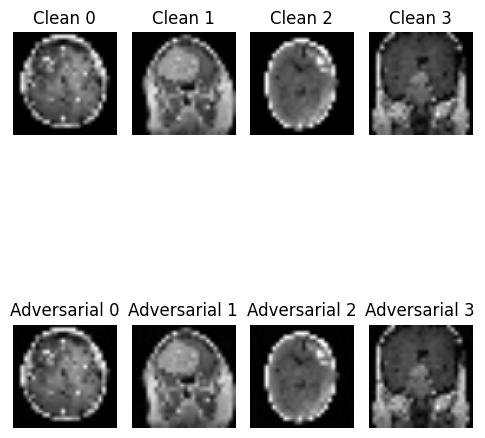

In [48]:
import cv2
import matplotlib.pyplot as plt

# Resize dimensions
new_height = 72
new_width = 72

# Select one sample from each class
samples_per_class = 1
clean_samples = []
adv_samples = []
for i in range(4):
    class_indices = np.where(np.argmax(y_test, axis=1) == i)[0]
    if len(class_indices) > 0:
        selected_index = np.random.choice(class_indices, samples_per_class, replace=False)[0]  # Get the integer index
        clean_samples.append(cv2.resize(x_test[selected_index], (new_width, new_height)))
        adv_samples.append(cv2.resize(np.array(x_test_adv_bim[selected_index]), (new_width, new_height)))


# Plot and save clean and adversarial examples
plt.figure(figsize=(12, 6))
for i in range(4):
    plt.subplot(2, 10, i + 1)
    plt.imshow(clean_samples[i], cmap='gray')
    plt.axis('off')
    plt.title(f'Clean {i}')
    plt.savefig(f'clean_example_{i}.png')  # Save the clean example

    plt.subplot(2, 10, i + 11)
    plt.imshow(adv_samples[i], cmap='gray')
    plt.axis('off')
    plt.title(f'Adversarial {i}')
    plt.savefig(f'adversarial_example_{i}.png')  # Save the adversarial example

plt.tight_layout()
plt.show()

In [49]:
#--------------------- C & W Attack -------------------

def cw_loss(y_true, y_pred, target_class, c=1.0):
    correct_logit = tf.reduce_sum(y_pred * y_true, axis=-1)
    wrong_logit = tf.reduce_max((1 - y_true) * y_pred - y_true * 1e10, axis=-1)
    loss = tf.maximum(0.0, c + wrong_logit - correct_logit)
    return loss

# Generate adversarial examples using C&W attack
def cw_attack(model, images, labels, target_class, c=1.0, learning_rate=0.1, num_iterations=10):
    images_adv = tf.identity(images)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    for i in range(num_iterations):
        with tf.GradientTape() as tape:
            tape.watch(images_adv)
            predictions = model(images_adv)
            loss = cw_loss(labels, predictions, target_class, c)
        
        gradients = tape.gradient(loss, images_adv)
        perturbation = tf.sign(gradients)
        images_adv = images_adv + 0.01 * perturbation  # Adjust the step size
        images_adv = tf.clip_by_value(images_adv, 0, 1)  # Clip the values to valid range
        
    return images_adv

# Example usage of C&W attack
target_class = 0  # Target class for misclassification
x_adv_cw = cw_attack(model, x_test, y_test, target_class)

In [50]:
#--------------------- C & W Attack Evaluation-------------------

# Evaluate the adversarially attacked model
_, adv_testing_accuracy = model.evaluate(x_adv_cw, y_test)
print(f'Adversarial Testing Accuracy: {adv_testing_accuracy}')

# Evaluate the success rate of the attack on the subset
y_pred_adv_subset = np.argmax(model.predict(x_adv_cw), axis=1)
success_rate_subset = np.mean(y_pred_adv_subset != np.argmax(y_test, axis=1))
print("Success rate of the CW attack on the subset:", success_rate_subset)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0042 - loss: 39.5702     
Adversarial Testing Accuracy: 0.010152284055948257
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Success rate of the CW attack on the subset: 0.9898477157360406


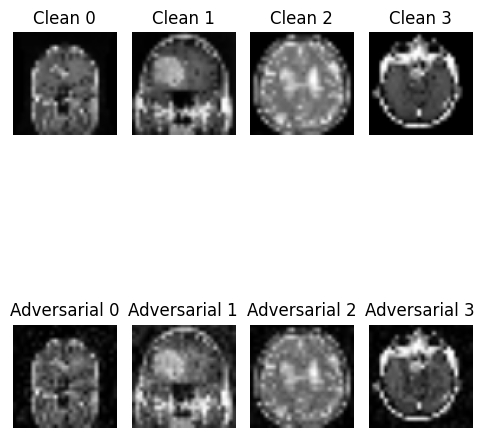

In [51]:
import cv2
import matplotlib.pyplot as plt

# Resize dimensions
new_height = 72
new_width = 72

# Select one sample from each class
samples_per_class = 1
clean_samples = []
adv_samples = []
for i in range(4):
    class_indices = np.where(np.argmax(y_test, axis=1) == i)[0]
    if len(class_indices) > 0:
        selected_index = np.random.choice(class_indices, samples_per_class, replace=False)[0]  # Get the integer index
        clean_samples.append(cv2.resize(x_test[selected_index], (new_width, new_height)))
        adv_samples.append(cv2.resize(np.array(x_adv_cw[selected_index]), (new_width, new_height)))


# Plot and save clean and adversarial examples
plt.figure(figsize=(12, 6))
for i in range(4):
    plt.subplot(2, 10, i + 1)
    plt.imshow(clean_samples[i], cmap='gray')
    plt.axis('off')
    plt.title(f'Clean {i}')
    plt.savefig(f'clean_example_{i}.png')  # Save the clean example

    plt.subplot(2, 10, i + 11)
    plt.imshow(adv_samples[i], cmap='gray')
    plt.axis('off')
    plt.title(f'Adversarial {i}')
    plt.savefig(f'adversarial_example_{i}.png')  # Save the adversarial example

plt.tight_layout()
plt.show()

In [52]:
#--------------------- PGD Attack -------------------

def pgd_attack(model, x, y, epsilon, alpha, num_iter):
    """
    PGD adversarial attack.
    
    Parameters:
        - model: The model to attack.
        - x: The input to generate adversarial examples.
        - y: The true labels.
        - epsilon: The maximum perturbation allowed.
        - alpha: The step size for each iteration.
        - num_iter: The number of iterations for the attack.
        
    Returns:
        - perturbed_x: The adversarial examples.
    """
    perturbed_x = tf.identity(x)

    for i in range(num_iter):
        with tf.GradientTape() as tape:
            tape.watch(perturbed_x)
            predictions = model(perturbed_x)
            loss = tf.keras.losses.categorical_crossentropy(y, predictions)

        gradients = tape.gradient(loss, perturbed_x)
        perturbed_x = tf.stop_gradient(perturbed_x + alpha * tf.sign(gradients))
        perturbed_x = tf.clip_by_value(perturbed_x, x - epsilon, x + epsilon)
        perturbed_x = tf.clip_by_value(perturbed_x, 0, 1)

    return perturbed_x

In [53]:
#--------------------- PGD Attack Evaluation -------------------

# Parameters for PGD attack
epsilon = 0.01
alpha = 0.01
num_iter = 200

# Apply PGD attack to test set
x_test_pgd = pgd_attack(model, x_test, y_test, epsilon, alpha, num_iter)

# Evaluate the adversarially attacked model
_, adv_testing_accuracy = model.evaluate(x_test_pgd, y_test)
print(f'Adversarial Testing Accuracy: {adv_testing_accuracy}')

# Evaluate the success rate of the attack on the subset
y_pred_adv_subset = np.argmax(model.predict(x_test_pgd), axis=1)
success_rate_subset = np.mean(y_pred_adv_subset != np.argmax(y_test, axis=1))
print("Success rate of the PGD attack on the subset:", success_rate_subset)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0516 - loss: 14.9935     
Adversarial Testing Accuracy: 0.09898477047681808
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Success rate of the PGD attack on the subset: 0.9010152284263959


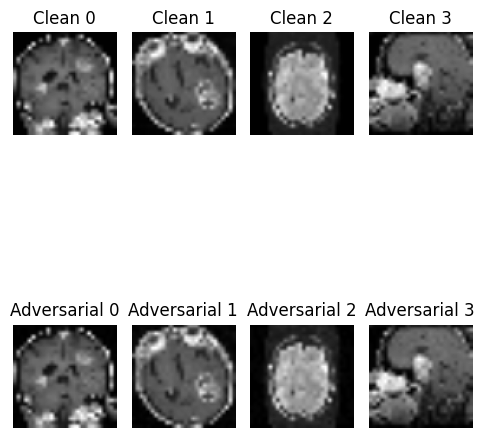

In [54]:
# Resize dimensions
new_height = 72
new_width = 72

# Select one sample from each class
samples_per_class = 1
clean_samples = []
adv_samples = []
for i in range(4):
    class_indices = np.where(np.argmax(y_test, axis=1) == i)[0]
    if len(class_indices) > 0:
        selected_index = np.random.choice(class_indices, samples_per_class, replace=False)[0]  # Get the integer index
        clean_samples.append(cv2.resize(x_test[selected_index], (new_width, new_height)))
        adv_samples.append(cv2.resize(np.array(x_test_pgd[selected_index]), (new_width, new_height)))


# Plot and save clean and adversarial examples
plt.figure(figsize=(12, 6))
for i in range(4):
    plt.subplot(2, 10, i + 1)
    plt.imshow(clean_samples[i], cmap='gray')
    plt.axis('off')
    plt.title(f'Clean {i}')
    plt.savefig(f'clean_example_{i}.png')  # Save the clean example

    plt.subplot(2, 10, i + 11)
    plt.imshow(adv_samples[i], cmap='gray')
    plt.axis('off')
    plt.title(f'Adversarial {i}')
    plt.savefig(f'adversarial_example_{i}.png')  # Save the adversarial example

plt.tight_layout()
plt.show()

In [59]:
#--------------------- JSMA Attack -------------------

def jsma_attack(model, x, y, epsilon=0.1, num_iterations=100, theta=1.0):
    x_adv = tf.identity(x)
    #y_target = tf.one_hot(y, depth=10)
    for _ in range(num_iterations):
        with tf.GradientTape() as tape:
            tape.watch(x_adv)
            prediction = model(x_adv)
            loss = tf.keras.losses.categorical_crossentropy(y, prediction)
        gradient = tape.gradient(loss, x_adv)
        # Calculate saliency map
        saliency_map = tf.reduce_max(tf.abs(gradient), axis=-1)
        # Perturb the input using saliency map
        perturbation = epsilon * tf.sign(gradient) * saliency_map[..., tf.newaxis]
        x_adv = x_adv + perturbation
        x_adv = tf.clip_by_value(x_adv, x - theta, x + theta)
        x_adv = tf.clip_by_value(x_adv, 0, 1)
    return x_adv.numpy()  # Convert to numpy array


In [62]:
#--------------------- JSMA Attack Evaluation -------------------

# JSMA attack parameters
epsilon_jsma = 0.1
num_iterations_jsma = 150
theta_jsma = 0.1

# Generate adversarial examples for the full test data
x_adv_jsma_all = jsma_attack(model, x_test, y_test, epsilon=epsilon_jsma, num_iterations=num_iterations_jsma, theta=theta_jsma)

# Evaluate the model on the adversarial examples
adv_loss_jsma, adv_acc_jsma = model.evaluate(x_adv_jsma_all, y_test)

# Calculate the success rate of the attack
success_rate_jsma = (1 - adv_acc_jsma) * 100  # Misclassification rate
print("JSMA Attack - Success Rate:", success_rate_jsma, "%")


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0571 - loss: 287.4585     
JSMA Attack - Success Rate: 91.62436574697495 %


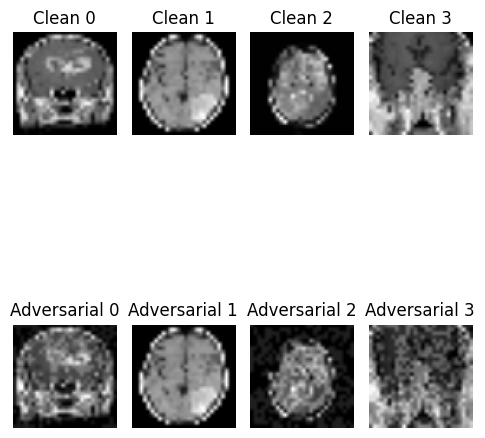

In [63]:
# Resize dimensions
new_height = 72
new_width = 72

# Select one sample from each class
samples_per_class = 1
clean_samples = []
adv_samples = []
for i in range(4):
    class_indices = np.where(np.argmax(y_test, axis=1) == i)[0]
    if len(class_indices) > 0:
        selected_index = np.random.choice(class_indices, samples_per_class, replace=False)[0]  # Get the integer index
        clean_samples.append(cv2.resize(x_test[selected_index], (new_width, new_height)))
        adv_samples.append(cv2.resize(np.array(x_adv_jsma_all [selected_index]), (new_width, new_height)))


# Plot and save clean and adversarial examples
plt.figure(figsize=(12, 6))
for i in range(4):
    plt.subplot(2, 10, i + 1)
    plt.imshow(clean_samples[i], cmap='gray')
    plt.axis('off')
    plt.title(f'Clean {i}')
    plt.savefig(f'clean_example_{i}.png')  # Save the clean example

    plt.subplot(2, 10, i + 11)
    plt.imshow(adv_samples[i], cmap='gray')
    plt.axis('off')
    plt.title(f'Adversarial {i}')
    plt.savefig(f'adversarial_example_{i}.png')  # Save the adversarial example

plt.tight_layout()
plt.show()